# Installing packages

In [ ]:
!pip install -r requirements.txt

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Loading data and pretrained models

In [ ]:
TRAIN_DATA_FILENAME = os.path.join('data', 'train_data.csv')
train_data = pd.read_csv(TRAIN_DATA_FILENAME)

In [ ]:
BERT_MODEL = BertForSequenceClassification.from_pretrained('bert-base-uncased')
BERT_TOKENIZER = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
LABELS = {
    'unrelated' : 0,
    'agree' : 1,
    'discuss': 2,
    'disagree': 4 
}

In [ ]:
def replace_labels_with_int(df : pd.DataFrame, col_name : str):
    df[col_name] = np.where(df[col_name] == 'unrelated', LABELS['unrelated'], df[col_name])
    df[col_name] = np.where(df[col_name] == 'agree', LABELS['agree'], df[col_name])
    df[col_name] = np.where(df[col_name] == 'discuss', LABELS['discuss'], df[col_name])
    df[col_name] = np.where(df[col_name] == 'disagree', LABELS['disagree'], df[col_name])

In [ ]:
def show_balance(df : pd.DataFrame):
  hist_data = pd.DataFrame({'stances': df['Stance']})
  hist_data.apply(pd.value_counts).plot(kind='bar', subplots=True)

In [ ]:
def make_undersampling(df : pd.DataFrame):
    rus = RandomUnderSampler(random_state=0)
    X = pd.DataFrame({'Headline': df['Headline'], 'articleBody': df['articleBody']})
    Y = pd.DataFrame({'Stance': df['Stance']})
    Y = Y.astype('int')
    return rus.fit_resample(X, Y)

In [ ]:
def compute_full_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def tokenize(batch):
    return BERT_TOKENIZER(batch['Headline'], batch['articleBody'], padding=True, truncation=True)

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


# Replacing str labels with integers

In [ ]:
replace_labels_with_int(train_data, 'Stance')
train_data

Headline  \
0      Police find mass graves with at least '15 bodi...   
1      Hundreds of Palestinians flee floods in Gaza a...   
2      Christian Bale passes on role of Steve Jobs, a...   
3      HBO and Apple in Talks for $15/Month Apple TV ...   
4      Spider burrowed through tourist's stomach and ...   
...                                                  ...   
62288  Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...   
62289  Brian Williams slams social media for speculat...   
62290  Mexico Says Missing Students Not Found In Firs...   
62291  US Lawmaker: Ten ISIS Fighters Have Been Appre...   
62292  Shots Heard In Alleged Brown Shooting Recordin...   

                                             articleBody Stance  
0      Danny Boyle is directing the untitled film\n\n...      0  
1      Hundreds of Palestinians were evacuated from t...      1  
2      30-year-old Moscow resident was hospitalized w...      0  
3      (Reuters) - A Canadian soldier was shot at the...      0  
4      Fear not arachnophobes, the story of Bunbury's...      4  
...                                                  ...    ...  
62288  (CNN) -- Boko Haram laughed off Nigeria's anno...      0  
62289  Along with unveiling the Apple Watch earlier t...      0  
62290  The bodies found in a mass grave were confirme...      1  
62291  Rep. Duncan Hunter (R-CA) told Greta Van Suste...      2  
62292  A married TV actor who met a young woman and k...      0  

[62293 rows x 3 columns]

# Checking class balance

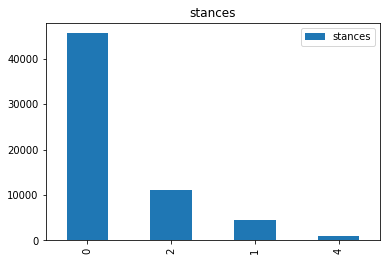

In [ ]:
show_balance(train_data)

# Performing under-sampling

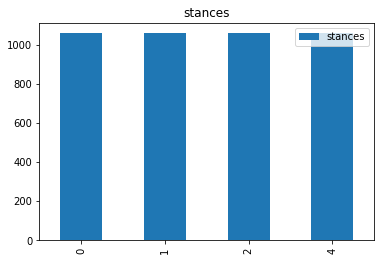

In [ ]:
train_data_resampled_x, train_data_resampled_y = make_undersampling(train_data)
train_data_resampled = pd.concat([train_data_resampled_x, train_data_resampled_y], axis=1)
show_balance(train_data_resampled)

# Splitting datasets into training and validation set

In [ ]:
train_data, validation_data = train_test_split(train_data_resampled, test_size=0.2)
train_dataset = Dataset.from_pandas(train_data)
validation_dataset = Dataset.from_pandas(validation_data)

In [ ]:
train_dataset_mapped = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset_mapped = validation_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
train_dataset_mapped.set_format('torch', columns=['input_ids', 'attention_mask', 'Stance'])
test_dataset_mapped.set_format('torch', columns=['input_ids', 'attention_mask', 'Stance'])

# Creating trainer for classification

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    num_train_epochs=3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_accumulation_steps=1
)

trainer = Trainer(
    model=BERT_MODEL,
    args=training_args,
    compute_metrics=compute_full_metrics,
    train_dataset=train_dataset_mapped,
    eval_dataset=test_dataset_mapped
)

# Training model

In [ ]:
trainer.train()

### After having problems with OOM (out of memory) I decided to stop working on that task due to lack of the time. Next step would be plotting computation metrics and saving trained model to the file